# Результаты исследования

Проанализировав действия пользователей на Афише, я выяснил, что: 

- Человек, пришедший на сервис год назад, то есть в **июне 2016 года**, приносит в **среднем 1.44$**. <br /> 
    - Так как целью является окупаемость за год, то тогда за привлечение нового пользователя мы готовы платить не больше этой суммы.
- За привлечение платящего пользователя мы готовы платить не больше **8.84 доллара**. <br />

Конечно, нужно учитывать, что это это выручка, поэтому надо посчитать себестоимость проданных билетов, чтобы получить более точную оценку величины, которую мы готовы тратить на привлечение новых пользователей. 


Ниже приведены расчеты, с помощью которых, я пришел к данным результатам.

In [1]:
# Это нужно для того, чтобы скрывать код

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Посмотреть код'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

##### Считываем данные

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

purchases = pd.read_excel('purchases.xlsx', sep='\t')
visits = pd.read_excel('visits.xlsx', sep='\t')

purchases['buy_ts_datetime'] = pd.to_datetime(purchases['buy_ts'], dayfirst=True)

visits['start_ts_datetime'] = pd.to_datetime(visits['start_ts'])

visits['end_ts_datetime'] = pd.to_datetime(visits['end_ts'])

KeyboardInterrupt: 

#### Объединяем таблицу с посещениями с таблицой покупок

In [ ]:
test_merge = pd.merge(visits, purchases, on='uid')

merged_df = test_merge[(test_merge['buy_ts_datetime'] >= test_merge['start_ts_datetime']) 
                       & (test_merge['buy_ts_datetime'] <= test_merge['end_ts_datetime'])]

merged_df.drop(['start_dt', 'start_ts', 'end_ts'], axis=1, inplace=True)

merged_df.drop_duplicates(subset=['uid', 'revenue', 'buy_ts_datetime'], keep='first', inplace=True)

merged_df['revenue'] = merged_df['revenue'].apply(lambda x: float(x.replace(',', '.')))

hide_toggle()

In [ ]:
merged_df.head()

Распределение количества покупок по месяцам за 2016 год

In [ ]:
print(purchases[purchases['buy_ts_datetime'].apply(lambda x: x.year) == 2016]['buy_ts_datetime'].apply(lambda date: date.month).value_counts())

hide_toggle()

Распределение количества покупок по месяцам за 2017 год

In [ ]:
print(purchases[purchases['buy_ts_datetime'].apply(lambda x: x.year) == 2017]['buy_ts_datetime'].apply(lambda date: date.month).value_counts())


hide_toggle()



Данные содержат информацию о действиях пользователей за 2016 и 2017 года

In [7]:
print(visits['start_ts_datetime'].apply(lambda x: x.year).value_counts())

hide_toggle()

2016    393747
2017    326932
Name: start_ts_datetime, dtype: int64


In [8]:
print(purchases['buy_ts_datetime'].apply(lambda x: x.year).value_counts())

hide_toggle()

2016    42186
2017    33530
Name: buy_ts_datetime, dtype: int64


Наши данные содержат информацию о действиях юзеров за 2016:
-  июнь
-  июль
-  август
-  сентябрь
-  октябрь
-  ноябрь
-  декабрь

и за 2017 год:
-  январь
-  февраль
-  март
-  апрель
-  май

### Посчитаем LTV - деньги, которые принес юзер с момента первого посещения сервиса

In [9]:
first_visit = pd.DataFrame(visits.groupby('uid')['start_ts_datetime'].min()) #Таблица с датой первого посещения 
first_visit.reset_index(level=0, inplace=True)
first_visit.rename(columns={'start_ts_datetime': 'first_visit'}, inplace=True)
first_visit['first_visit'] = first_visit['first_visit'].apply(lambda x: str(x.month) + ' - ' + str(x.year))

visits['month_year'] = visits['start_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))

merged_df['month_year_visit'] = merged_df['start_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))
merged_df['month_year_buy'] = merged_df['buy_ts_datetime'].apply(lambda x: str(x.month) + ' - ' + str(x.year))
merged_df = pd.merge(merged_df, first_visit, on='uid')

uid_total_revenue = pd.DataFrame(merged_df.groupby('uid')['revenue'].sum()).reset_index() # сколько принес денег каждый чел
uid_total_revenue.rename(columns={'revenue': 'total revenue'}, inplace=True)

merged_df = pd.merge(merged_df, uid_total_revenue, on='uid')

rev = merged_df[['uid', 'first_visit', 'total revenue']].drop_duplicates(keep='first')
rev = pd.DataFrame(rev.groupby('first_visit')['total revenue'].sum()).reset_index()

monthly_revenue = pd.DataFrame(merged_df.groupby('month_year_visit')['revenue'].sum()).reset_index().sort_values(
                                                                                            by='revenue', ascending=False)
monthly_revenue.rename(columns={'revenue': 'revenue a month'}, inplace=True)


first_visit_cnt = pd.DataFrame(first_visit.groupby('first_visit')['uid'].nunique()).reset_index()
# кол-во зарегистрированных юзеров по месяцам 
first_visit_cnt.rename(columns={'uid': 'uids_registered'}, inplace=True)


payers_regs = pd.DataFrame(merged_df.groupby('first_visit')['uid'].nunique()).reset_index()
# кол-во зарегестрированных платящих пользователей по месяцам
payers_regs.rename(columns={'uid': 'payers_registered'}, inplace=True)


visits_cnt = pd.DataFrame(visits.groupby(['month_year'])['uid'].nunique()).reset_index() 
#кол-во посещений уникальных юзеров по месяцам 
visits_cnt.rename(columns={'uid': 'unique_uids_visited', 'month_year': 'first_visit'}, inplace=True)


visits_cnt_all = pd.DataFrame(visits.groupby(['month_year'])['uid'].count()).reset_index()
# кол-во посещений по месяцам
visits_cnt_all.rename(columns={'uid': 'all_visits', 'month_year': 'first_visit'}, inplace=True)


final_df = pd.merge(pd.merge(pd.merge(pd.merge(visits_cnt_all, visits_cnt), first_visit_cnt), payers_regs), rev)
final_df['LTV uid'] = round(final_df['total revenue']/final_df['uids_registered'], 2 ) # сколько денег приносит 
                                                                                       # один uid за все время    
final_df['LTV payer'] = round(final_df['total revenue']/final_df['payers_registered'], 2 ) # сколько денег приносит
                                                                                           # плятящий пользователь 
                                                                                           #за все время
final_df = pd.merge(final_df, monthly_revenue, left_index=True, right_index=True)
final_df.drop('month_year_visit', axis=1, inplace=True)

final_df['money_per_visit'] = round(final_df['revenue a month']/final_df['all_visits'], 2) # сколько денег приносит один визит

final_df['money_per_uid_visit'] = round(final_df['revenue a month']/final_df['unique_uids_visited'], 2)#сколько денег приносит 
                                                                                                # визит одного пользователя
final_df['month'] = final_df['first_visit'].apply(lambda x: int(x[:2]))

final_df['year'] = final_df['first_visit'].apply(lambda x: int(x[-4:]))

sorted_df = pd.DataFrame(final_df.groupby(['year', 'month'])['total revenue'].sum()).reset_index()
sorted_df['first_visit'] = sorted_df['month'].apply(lambda x: str(x)).values + ' - ' + sorted_df['year'].apply(lambda x: str(x)).values

hide_toggle()

Чтобы рассчитать LTV, нужно сгруппировать пользователей по дате первого захода на сервис и посчитать по каждой группе сумму выручки за все время.


Например, видим, что клиенты, которые в первый раз пришли в июне 2016 года за все время после первого визита принесли **74.339$** 

In [10]:
rev.sort_values(by='total revenue', ascending=False)

,first_visit,total revenue
8,6 - 2016,74339.46
11,9 - 2016,42108.79
1,10 - 2016,40160.43
3,12 - 2016,39452.73
2,11 - 2016,35603.62
9,7 - 2016,27416.66
0,1 - 2017,22052.41
10,8 - 2016,20694.26
4,2 - 2017,20566.14
5,3 - 2017,19328.77


На графике ниже видно, что чем больше с нами клиент, тем больше он тратит. 

Понятно, что люди пришедшие на сервис в конце анализируемого периода имели меньше возможности потратиться, так как у них было меньше времени, поэтому и наблюдается спад.

Также наблюдается всплеск в период с сентября по декабрь, вероятнее всего, из-за бОльшего количества проводимых мероприятий в этот период. 

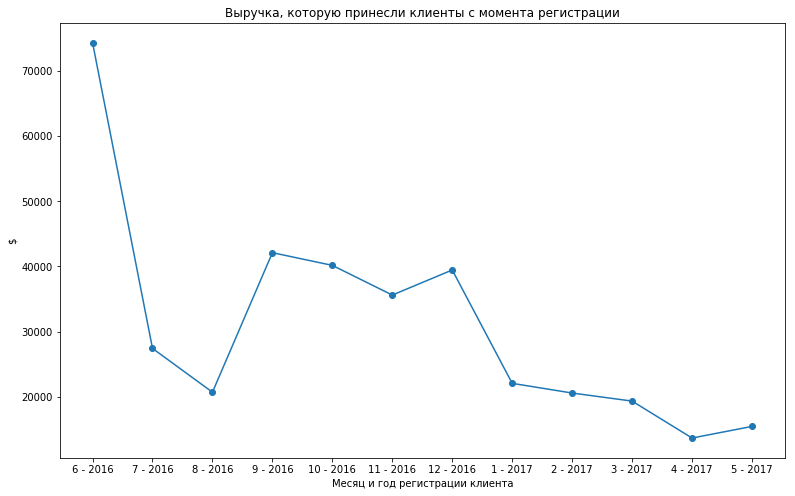

In [11]:
plt.figure(figsize=(13,8))
plt.plot(list(sorted_df['total revenue']), marker='o')

plt.xticks(range(12), list(sorted_df['first_visit']))

plt.xlabel('Месяц и год регистрации клиента')
plt.ylabel('$')
plt.title('Выручка, которую принесли клиенты с момента регистрации')
plt.show();

hide_toggle()

Давайте посмотрим на выручку по месяцам (сколько всего было продано в каждом месяце), чтобы посмотреть на динамику продаж по месяцам.

Действительно, мы можем наблюдать сезонность в период с сентября по декабрь.

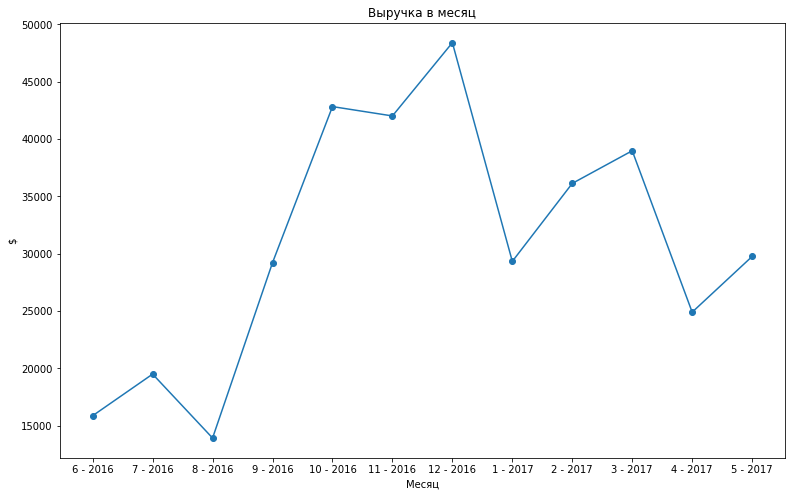

In [12]:
rev_a_month = pd.DataFrame(final_df.groupby(['year', 'month'])['revenue a month'].sum()).reset_index()

rev_a_month['first_visit'] = rev_a_month['month'].apply(lambda x: str(x)).values + ' - ' + rev_a_month['year'].apply(lambda x: str(x)).values

plt.figure(figsize=(13,8))
plt.plot(list(rev_a_month['revenue a month']), marker='o')

plt.xticks(range(12), list(rev_a_month['first_visit']))

plt.xlabel('Месяц')
plt.ylabel('$')
plt.title('Выручка в месяц')
plt.show();

hide_toggle()



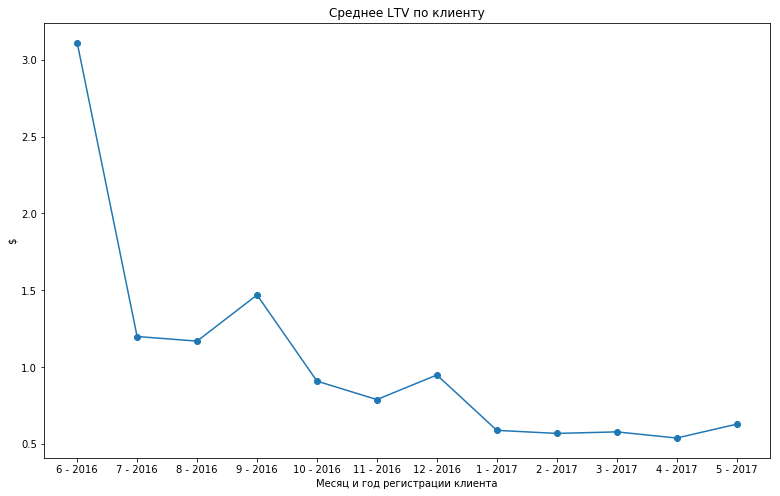

In [13]:
ltv_uid = pd.DataFrame(final_df.groupby(['year', 'month'])['LTV uid'].sum()).reset_index()

ltv_uid['first_visit'] = ltv_uid['month'].apply(lambda x: str(x)).values + ' - ' + ltv_uid['year'].apply(lambda x: str(x)).values

plt.figure(figsize=(13,8))
plt.plot(list(ltv_uid['LTV uid']), marker='o')

plt.xticks(range(12), list(ltv_uid['first_visit']))

plt.xlabel('Месяц и год регистрации клиента')
plt.ylabel('$')
plt.title('Среднее LTV по клиенту')
plt.show();

hide_toggle()

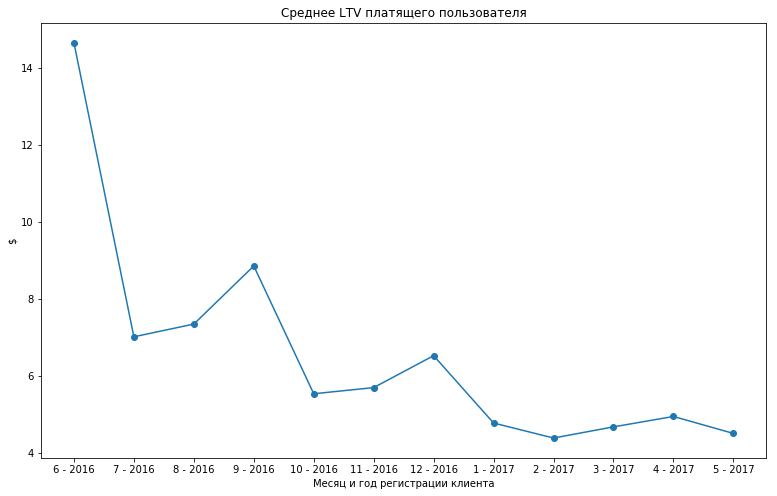

In [14]:
ltv_payer = pd.DataFrame(final_df.groupby(['year', 'month'])['LTV payer'].sum()).reset_index()

ltv_payer['first_visit'] = ltv_payer['month'].apply(lambda x: str(x)).values + ' - ' + ltv_payer['year'].apply(lambda x: str(x)).values

plt.figure(figsize=(13,8))
plt.plot(list(ltv_payer['LTV payer']), marker='o')

plt.xticks(range(12), list(ltv_payer['first_visit']))

plt.xlabel('Месяц и год регистрации клиента')
plt.ylabel('$')
plt.title('Среднее LTV платящего пользователя')
plt.show();

hide_toggle()

Давайте посмотрим на таблицу, которая содержит следующие важные показатели:
- **all_visits** - Общее количество посещений в месяц
- **unique_uids_visited** - Кол-во уникальных uid, посетивших Афишу
- **uids_registered** - Кол-во uid, которые зарегистрировались на Афише в конкретном месяце
- **payers_registered** - Кол-во платящих (совершили > 0 покупок) uid, которые зарегистрировались на Афише в конкретном месяце
- **total_revenue** - Выручка, которую принесли клиенты за все время с моменты регистрации 
- **LTV uid** - Среднее LTV каждого пользователя
- **LTV payer** - Среднее LTV платящего пользователя
- **revenue a month** - Выручка по месяцам (сколько всего было продано в каждом месяце)
- **money_per_visit** - Cколько денег приносит один визит (revenue a month/all_visits)
- **money_per_visit** - Cколько денег приносит визит одного пользователя(revenue a month/unique_uids_visited)

In [15]:
final_df.drop(['month', 'year'], axis=1).sort_values( by=['LTV uid', 'LTV payer'], ascending=False)

,first_visit,all_visits,unique_uids_visited,uids_registered,payers_registered,total revenue,LTV uid,LTV payer,revenue a month,money_per_visit,money_per_uid_visit
8,6 - 2016,32935,23926,23926,5073,74339.46,3.11,14.65,15873.54,0.48,0.66
11,9 - 2016,48328,34114,28735,4757,42108.79,1.47,8.85,29217.10,0.60,0.86
9,7 - 2016,35409,25352,22779,3912,27416.66,1.20,7.01,19501.34,0.55,0.77
10,8 - 2016,28803,21054,17688,2820,20694.26,1.17,7.34,13927.44,0.48,0.66
3,12 - 2016,83820,55090,41313,6054,39452.73,0.95,6.52,48393.27,0.58,0.88
1,10 - 2016,75873,52736,43906,7260,40160.43,0.91,5.53,42821.86,0.56,0.81
2,11 - 2016,88579,57289,44850,6262,35603.62,0.79,5.69,42006.80,0.47,0.73
7,5 - 2017,53693,36824,24675,3429,15440.87,0.63,4.50,29756.15,0.55,0.81
0,1 - 2017,74137,51277,37361,4625,22052.41,0.59,4.77,29329.11,0.40,0.57
5,3 - 2017,71639,48668,33234,4142,19328.77,0.58,4.67,38971.17,0.54,0.80


In [16]:
final_df.drop(['month', 'year'], axis=1).sort_values( by=['LTV uid', 'LTV payer'], ascending=False)

,first_visit,all_visits,unique_uids_visited,uids_registered,payers_registered,total revenue,LTV uid,LTV payer,revenue a month,money_per_visit,money_per_uid_visit
8,6 - 2016,32935,23926,23926,5073,74339.46,3.11,14.65,15873.54,0.48,0.66
11,9 - 2016,48328,34114,28735,4757,42108.79,1.47,8.85,29217.10,0.60,0.86
9,7 - 2016,35409,25352,22779,3912,27416.66,1.20,7.01,19501.34,0.55,0.77
10,8 - 2016,28803,21054,17688,2820,20694.26,1.17,7.34,13927.44,0.48,0.66
3,12 - 2016,83820,55090,41313,6054,39452.73,0.95,6.52,48393.27,0.58,0.88
1,10 - 2016,75873,52736,43906,7260,40160.43,0.91,5.53,42821.86,0.56,0.81
2,11 - 2016,88579,57289,44850,6262,35603.62,0.79,5.69,42006.80,0.47,0.73
7,5 - 2017,53693,36824,24675,3429,15440.87,0.63,4.50,29756.15,0.55,0.81
0,1 - 2017,74137,51277,37361,4625,22052.41,0.59,4.77,29329.11,0.40,0.57
5,3 - 2017,71639,48668,33234,4142,19328.77,0.58,4.67,38971.17,0.54,0.80


### Вывод

- Судя по таблице человек, пришедший на Афишу год назад, то есть в **июне 2016 года**, приносит в **среднем 3.11$**. <br /> 
- Платящий пользователь приносит сервису **14.65 доллара**. <br />

Эта оценка, кажется, очень оптимистичной, так как пользователи, пришедшие в июле, принесли в среднем **1.2** доллара, а платящие всего **7.01 $**, что примерно в два раза меньше чем принесли июньские. Маловероятно, что за месяц платежи пользователей увеличатся в два раза. Поэтому давайте построим следущий график, где:
- Берутся недельные когорты, то есть группируем пользователей по неделям и смотрим на их кумулятивную сумму платежей
- Зеленая кривая - усредненная кривая платежей по каждой когорте
- Пунктирная кривая - апроксимация зеленой кривой логарифмом
    
    


 



In [18]:
first_visit_date = pd.DataFrame(visits.groupby('uid')['start_ts_datetime'].min()).reset_index()

first_visit_date['login_time'] = (first_visit_date['start_ts_datetime'].astype(int) / 1_000_000_000).astype(int)

profiles = first_visit_date[['uid','login_time']]
profiles = profiles.rename(columns = {'uid': 'user_id', 'login_time' : 'login_time'})

first_visit_date_payers = pd.DataFrame(merged_df.groupby('uid')['start_ts_datetime'].min()).reset_index()
first_visit_date_payers['login_time'] = (first_visit_date_payers['start_ts_datetime'].astype(int) / 1_000_000_000).astype(int)
profiles_payers = first_visit_date_payers[['uid','login_time']]
profiles_payers = profiles_payers.rename(columns = {'uid': 'user_id', 'login_time' : 'login_time'})

pays = purchases[['uid', 'revenue', 'buy_ts_datetime']]
pays['pay_time'] = (pays['buy_ts_datetime'].astype(int) / 1_000_000_000).astype(int)
pays = pays.rename(columns = {'uid': 'user_id', 'revenue' : 'pay_sum'})[['user_id','pay_sum','pay_time']]

pays['pay_sum'] = pays['pay_sum'].apply(lambda x: x.replace(',', '.')).astype(float)

hide_toggle()

In [19]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import errno
import numpy as np

import calendar
from datetime import datetime
import time
import pytz
import warnings
from scipy.optimize import curve_fit, OptimizeWarning

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

            
class ShowContext():
    def __init__(self, title, xlabel, ylabel, figsize=(12,7), show_legend=True):
        self._title = title
        self._xlabel = xlabel
        self._ylabel = ylabel
        self._figsize = figsize
        self._show_legend = show_legend

    def __enter__(self):
        fig = plt.figure(figsize=self._figsize)
        plt.title(self._title)
        plt.xlabel(self._xlabel)
        plt.ylabel(self._ylabel)
        plt.minorticks_on()
        
        # Customize the major grid
        plt.grid(which='major', linestyle='-', color=[0.8]*3)
        # Customize the minor grid
        plt.grid(which='minor', linestyle=':', color=[0.9]*3)
        return fig

    def __exit__(self, *args):
        if self._show_legend:
            plt.legend()
        
def to_ut(x, fmt='%Y-%m-%d %H:%M:%S'):
    if x=='nan':
        return None
    else:
        return calendar.timegm(datetime.strptime(x, fmt).timetuple())

def get_ut(year, month, day):
    return  calendar.timegm(datetime(year, month, day).timetuple())

hide_toggle()

In [20]:
def func(x, a, b, c):
#     return 50*np.tanh(a)*np.log(x + 500*np.tanh(b)) + 100*np.tanh(c)
    return a*np.log(x + b) + c

def get_cohs(profiles, payments):
    COH_SIZE = 7
    # Add cohorts numbers
    MIN_TS = profiles['login_time'].min()
    profiles['coh'] = (profiles['login_time'] - MIN_TS) // (COH_SIZE*3600*24)
    profiles = profiles.loc[profiles['coh'] >= 0]
    cohs_sizes = profiles.groupby('coh').agg({'user_id': 'nunique', 
                                        'login_time': 'max'}
                                      ).reset_index().rename(index=str, columns={'user_id': 'coh_size'})
    cohs_sizes['last_day'] = max(payments['pay_time'].max(), cohs_sizes['login_time'].max())
    cohs_sizes['max_day'] = (cohs_sizes['last_day'] - cohs_sizes['login_time']) // (24*3600)
    cohs_sizes = cohs_sizes[['coh', 'coh_size', 'max_day']]
    zeros_df = pd.concat([pd.DataFrame({'coh': coh, 
                                        'coh_size': coh_size,
                                        'days_passed': list(range(int(max_day)+1))
                      }) for idx, (coh, coh_size, max_day) in cohs_sizes.iterrows()])
        
    project = pd.merge(profiles, payments, on='user_id') 
    project['days_passed'] = (project['pay_time'] - project['login_time']) // (24*3600)
        
    project_sum = project.groupby(['coh', 'days_passed'])['pay_sum'].sum().reset_index()
    project_sum = pd.merge(zeros_df, project_sum, on=['coh', 'days_passed'], how='left').fillna(0)
    return project, cohs_sizes, project_sum

hide_toggle()

In [21]:
payments = pays.copy()

<IPython.core.display.Javascript object>


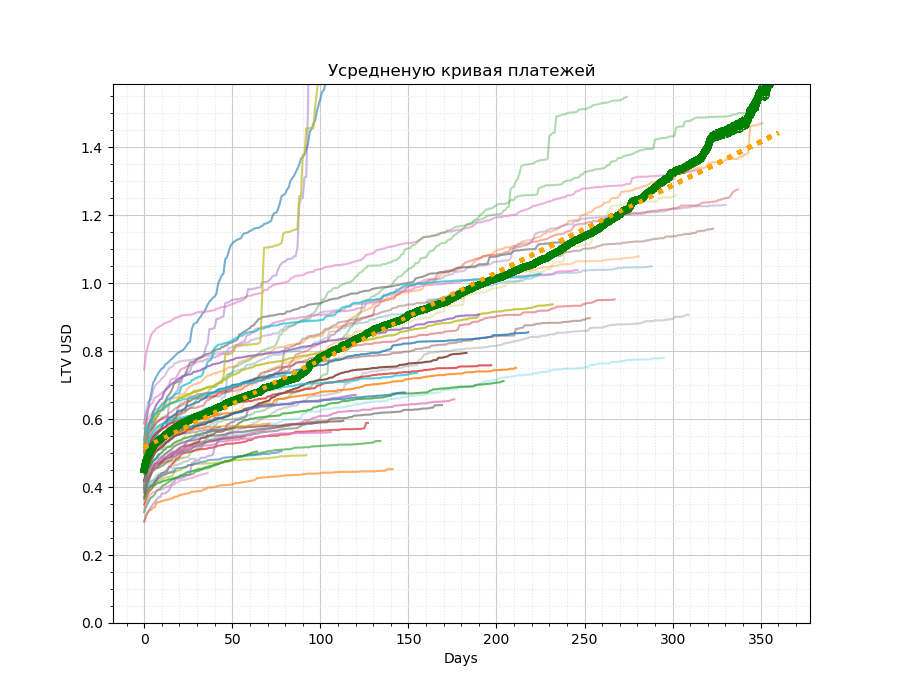

100%|██████████| 53/53 [16:06<00:00, 21.37s/it]


In [22]:
from tqdm import tqdm
ltv={}
res_popt = {}
project, cohs_sizes, project_sum = get_cohs(profiles, payments)    
project_sum_upd = project_sum.copy()
data_avg = project_sum_upd.groupby('days_passed').agg({'pay_sum': 'sum', 
                                                               'coh_size': 'sum'}).reset_index()
data_avg['ARPU'] = data_avg['pay_sum'] / data_avg['coh_size']
data_avg['LTV'] = data_avg['ARPU'].cumsum() #/ 60
data_avg['sigma'] = 1 / (data_avg['coh_size']**0.5)
data_mean_all = project_sum_upd.copy()
data_mean_all['cum_sum'] = project_sum_upd.groupby('coh')['pay_sum'].cumsum()
data_mean_all['LTV'] = data_mean_all['cum_sum'] / data_mean_all['coh_size']
data_mean_all['LTV'] = data_mean_all['LTV'] #/ 60
data_mean_all['sigma'] = 1 / (data_mean_all['coh_size'])**0.5
n_players = int(project_sum_upd[['coh', 'coh_size']].drop_duplicates()['coh_size'].sum())

title = 'Усредненую кривая платежей'
with ShowContext(title, 'Days', 'LTV USD', show_legend=False, figsize=(9,7)) as sc:
    sns.set_palette(sns.color_palette('husl', project_sum_upd['coh'].nunique()))
    t = 0
    for coh, group in tqdm(data_mean_all.groupby('coh')):
        coh_cnt = int(cohs_sizes.loc[(cohs_sizes['coh'] == coh)]['coh_size'])
        plt.plot(group['days_passed'], group['LTV'],alpha = coh_cnt / project_sum_upd['coh_size'].max())    
        plt.plot(data_avg['days_passed'], data_avg['LTV'], linewidth=5, color='green')
        Q=1.645
        delta = data_avg['LTV'] * Q * data_avg['sigma']
        plt.fill_between(data_avg['days_passed'], data_avg['LTV']-delta, data_avg['LTV']+delta,
                            color='green', alpha=0.4)
        popt, pcov = curve_fit(func, data_avg['days_passed'], data_avg['LTV'].astype('float'),
                          sigma=data_avg['sigma'], absolute_sigma=True, maxfev = 100000, p0=(1,1,-1))
        days = np.linspace(0, 360, 361)
        LTV = [func(x, *popt) for x in days]
        #Взвешенное среднее всех когорт
        plt.plot(days, LTV, linewidth=3, color='orange', linestyle=':')
        plt.ylim((0,func(360, *popt)*1.1))
        plt.show()

Видим, что усредненная кривая является почти линейной. Действительно, судя по графику, данные по клиентам, которые пришли в июне являются нерепрезентативными. И наиболее точной оценкой будет LTV в размере **1.44$**

In [23]:
LTV[360]

1.4425276384536119

### Построим когорты только платящих пользователей

<IPython.core.display.Javascript object>


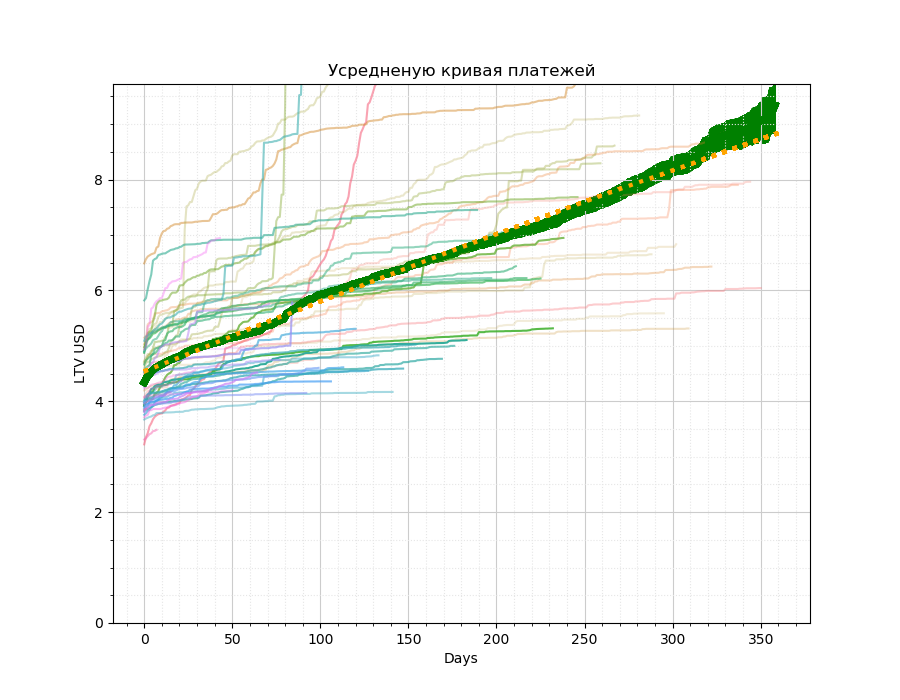

100%|██████████| 53/53 [00:18<00:00,  2.41it/s]


In [24]:
from tqdm import tqdm
ltv={}
res_popt = {}
project, cohs_sizes, project_sum = get_cohs(profiles_payers, payments)    
project_sum_upd = project_sum.copy()
data_avg = project_sum_upd.groupby('days_passed').agg({'pay_sum': 'sum', 
                                                               'coh_size': 'sum'}).reset_index()
data_avg['ARPU'] = data_avg['pay_sum'] / data_avg['coh_size']
data_avg['LTV'] = data_avg['ARPU'].cumsum() #/ 60
data_avg['sigma'] = 1 / (data_avg['coh_size']**0.5)
data_mean_all = project_sum_upd.copy()
data_mean_all['cum_sum'] = project_sum_upd.groupby('coh')['pay_sum'].cumsum()
data_mean_all['LTV'] = data_mean_all['cum_sum'] / data_mean_all['coh_size']
data_mean_all['LTV'] = data_mean_all['LTV'] #/ 60
data_mean_all['sigma'] = 1 / (data_mean_all['coh_size'])**0.5
n_players = int(project_sum_upd[['coh', 'coh_size']].drop_duplicates()['coh_size'].sum())

title = 'Усредненую кривая платежей'
with ShowContext(title, 'Days', 'LTV USD', show_legend=False, figsize=(9,7)) as sc:
    sns.set_palette(sns.color_palette('husl', project_sum_upd['coh'].nunique()))
    t = 0
    for coh, group in tqdm(data_mean_all.groupby('coh')):
        coh_cnt = int(cohs_sizes.loc[(cohs_sizes['coh'] == coh)]['coh_size'])
        plt.plot(group['days_passed'], group['LTV'],alpha = coh_cnt / project_sum_upd['coh_size'].max())    
        plt.plot(data_avg['days_passed'], data_avg['LTV'], linewidth=5, color='green')
        Q=1.645
        delta = data_avg['LTV'] * Q * data_avg['sigma']
        plt.fill_between(data_avg['days_passed'], data_avg['LTV']-delta, data_avg['LTV']+delta,
                            color='green', alpha=0.4)
        popt, pcov = curve_fit(func, data_avg['days_passed'], data_avg['LTV'].astype('float'),
                          sigma=data_avg['sigma'], absolute_sigma=True, maxfev = 100000, p0=(1,1,-1))
        days = np.linspace(0, 360, 361)
        LTV = [func(x, *popt) for x in days]
        #Взвешенное среднее всех когорт
        plt.plot(days, LTV, linewidth=3, color='orange', linestyle=':')
        plt.ylim((0,func(360, *popt)*1.1))
        plt.show()

Здесь, мы видим такую же ситуацию. Очевидно, что оценка LTV платящего пользователя в **14.65$** является оптимистичной. 

Наиболее вероятным LTV будет **8.84 доллара**

In [25]:
LTV[360]

8.841320940434741

### Источники визита  и устройства

In [26]:
print(visits['device'].value_counts(normalize=True))
hide_toggle()

desktop    0.731555
touch      0.268445
Name: device, dtype: float64


In [27]:
print(merged_df['device'].value_counts(normalize=True)) # Видим, что в основном покупают с копьютеров
hide_toggle()


desktop    0.838845
touch      0.161155
Name: device, dtype: float64



#### Посмотрим сколько переходов и покупок по каналам для desktop и touch


С каких каналов юзеры совершают покупки на компьютере


In [28]:

print(merged_df[merged_df['device'] == 'desktop']['source_id'].value_counts(normalize=True) )

hide_toggle()

4     0.227965
5     0.222707
3     0.214362
1     0.146865
2     0.133593
10    0.028687
9     0.025774
7     0.000047
Name: source_id, dtype: float64


С каких каналов юзеры совершают покупки на смартфоне

In [29]:
print(merged_df[merged_df['device'] == 'touch']['source_id'].value_counts(normalize=True))

hide_toggle()

4     0.297492
3     0.177184
1     0.159974
2     0.154729
5     0.152516
10    0.033929
9     0.024176
Name: source_id, dtype: float64


In [30]:
desktop_source_visits = pd.DataFrame(visits[visits['device'] == 'desktop'].groupby('source_id')['uid'].nunique())
#Кол-во посещений пользователей через desktop по каналам 

desktop_source_revenue = pd.DataFrame(merged_df[merged_df['device'] == 'desktop'].groupby('source_id')['revenue'].sum())
#Выручка от пользователей(desktop) по каналам

desktop_source = pd.merge(desktop_source_visits, desktop_source_revenue, left_index=True, right_index=True)
desktop_source.rename(columns={'uid': 'unique_uids'}, inplace=True)

desktop_source['rev_per_uid'] = round(desktop_source['revenue']/ desktop_source['unique_uids'], 2)

touch_source_visits = pd.DataFrame(visits[visits['device'] == 'touch'].groupby('source_id')['uid'].nunique())
#Кол-во посещений пользователей через touch по каналам 

touch_source_revenue = pd.DataFrame(merged_df[merged_df['device'] == 'touch'].groupby('source_id')['revenue'].sum())
#Выручка от пользователей(touch) по каналам

touch_source = pd.merge(touch_source_visits, touch_source_revenue, left_index=True, right_index=True)
touch_source.rename(columns={'uid': 'unique_uids'}, inplace=True)

hide_toggle()

Посмотрим сколько в среднем каждый канал приносит денег 

Видим, что каналы **№1** и **№2** в среднем приносят больше выручки.


In [31]:
desktop_source.sort_values(by='rev_per_uid', ascending=False)


,unique_uids,revenue,rev_per_uid
source_id,,,
1,22720,58938.50,2.59
2,30673,66207.33,2.16
5,76900,67550.12,0.88
4,101019,59794.51,0.59
3,106297,56474.49,0.53
10,10664,5183.40,0.49
9,11809,5389.07,0.46
7,62,3.34,0.05


Для смартфонов наблюдается похожая ситуация


In [32]:
touch_source['rev_per_uid'] = round(touch_source['revenue']/ touch_source['unique_uids'], 2)
touch_source.sort_values(by='rev_per_uid', ascending=False)

,unique_uids,revenue,rev_per_uid
source_id,,,
1,10724,9977.90,0.93
2,15181,10326.32,0.68
4,53773,14567.36,0.27
5,28755,6823.12,0.24
3,35520,7805.46,0.22
9,4075,896.17,0.22
10,4440,886.99,0.20


Нужно понять, что физически из себя предстваляет каждый канал и уже после этого мы сможем дать конкретную рекоммендацию о том, где и в каком количестве лучше закупать трафик.

Судя по нашему анализу, наибольшей конверисией обладают каналы **№1** и **№2** как для desktop, так и для touch.